In [337]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import j1
from statistics import mean
import math

## 4.1 Read the Data and make a plot

Your code should read the data file, capturing any information from the metadata that it needs to solve the other tasks, and read the numerical data, separating out the dimensions of the diffraction pattern into two 1D arrays and the diffraction pattern intensity as a 2D array.

Your code should make a plot to visualise the diffraction data. It is up to you to decide the format that does this most clearly, but the plot should show the dimensions of the data as read from the file as well as the intensity data itself and your plot title must include your IT user name (e.g. pY22spqr).

In [338]:
#File path to assesed data
filename = '/Users/zosiawilk/Downloads/assessment_data_py22zw (4).dat'

In [339]:
def read_diffraction_data(filename):
    """
    Function to read the data file and extract metadata and numerical data (intensity, sin phi and sin_theta)
    for the diffraction pattern. 

    Parameters
    ----------
    filename: string 
        Path to a data file

    Returns
    -------
    metadata: dictionary 
    intensity: array
    sin_phi: array
    sin_theta: array
    """
    try:
        with open(filename, 'r') as file:
            content = file.readlines()

        #Extracting metadata
        metadata_start = content.index('<MetaDataAtStart>\n')
        metadata_end = content.index('</MetaDataAtStart>\n')
        metadata_text = ''.join(content[metadata_start + 1:metadata_end])
        metadata = {}
        for line in metadata_text.strip().split('\n'):
            key, value = line.split('=')
            metadata[key.strip()] = value.strip()
    
        #Extracting first row, first column and intensity data
        data_lines = []
        i = 0
        for line in content[metadata_end + 2:]:
            if i == 0:
                first_row = line.split('\t')[1:]
                i += 1
            else:
                data_lines.append(line.split('\t'))
        
        data = np.array(data_lines, dtype=float)
        first_column = data[:, 0]
        data = data[:, 1:]


        if metadata["As Projected"] == 'True': 
            """
            Calculates sin_phi and sin_theta if the data is "As Projected" from the Distance to Screen 
            and horizonatal and vertical data
            """
            x = np.array(first_column, dtype = float)*1e-3 #converting mm to meters
            y = np.array(first_row, dtype =float)*1e-3 #converting mm to meters
            distance = float(metadata["Distance to Screen (m)"])

            phi = np.arctan(y/distance)
            theta = np.arctan(x/distance)

            sin_phi = np.sin(phi)
            sin_theta = np.sin(theta)
            intensity = data
            
        else:
            sin_phi = np.array(first_row, dtype = float)
            sin_theta = np.array(first_column, dtype = float)
            intensity = data

            assert first_column != first_row
            
        return metadata, intensity, sin_phi, sin_theta

    except IOError: 
        print("Something went wrong, could not read the file!")
        return None, None, None, None
     
    


metadata, intensity, sin_phi, sin_theta = read_diffraction_data(filename)

In [340]:
def plot_diffraction_data(intensity=intensity, sin_phi = sin_phi, sin_theta=sin_theta):
    """
    Function to plot the diffraction data. 
    
    Parameters
    ----------
    intensity: array
    sin_phi: array
    sin_theta: array

    Returns
    -------
    Plot of the diffraction data
    """

    plt.figure()
    plt.imshow(intensity, extent=(sin_phi.min(), sin_phi.max(),
                         sin_theta.min(), sin_theta.max()), aspect='auto', interpolation = "bicubic", cmap='RdBu', vmin=0, vmax=intensity.max())
    
    plt.colorbar(label='Intensity')
    plt.xlabel('Distance mm')
    plt.ylabel('Distance mm')
    plt.title(f'Diffraction Data for py22zw')
    plt.show()


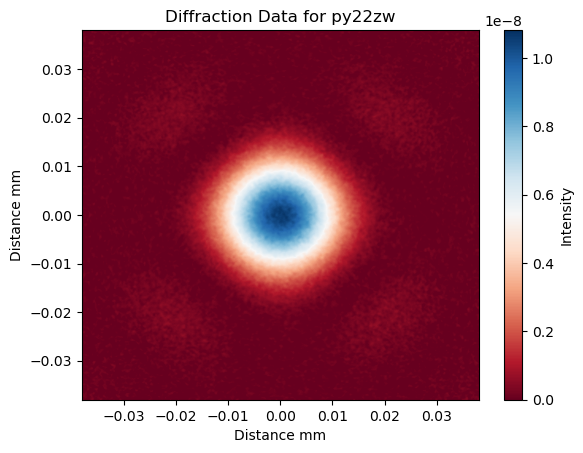

In [341]:
plot_diffraction_data()

## 4.2 Extract a slice of data for  sin𝜙=0 and fit with a suitable function.

Your code may need to convert the dimensions given in the file to  sin𝜃,sin𝜙
  if the As Projected option was used. If this is the case, you will find a metadata item that tells you the distance between the screen and the aperture in metres and the data in the file is the horizontal or vertical distance in mm. You can use this information to work out the corresponding 𝜃 and  𝜙 and hence  sin𝜃 and  sin𝜙.

If you are using the option of a variable wavelength, you will also need to extract the correct wavelength from the metadata in order to calculate the appropriate value of 𝑘.

If your code is working with a fixed aperture shape then you can immediately determine which is the correct function to fit the data with. If your code is using a randomly chose aperture, then you need to use the approach described in section 2 to decide which fitting function works best, and hence what the shape of the aperture is. From these fits you will get a value of 𝑊 (or  𝐷) and an uncertainty. This will be "dimension 1" when returning the results.

You should also make a plot showing the data you were fitting and the fit(s) found. If you have fitted the data with more than one function, you should indicate on the legend or with a text annotation, which function is the best fit.

In [342]:
#Extracting wavelength from the metadata and calculate k
wavelength = float(metadata['Wavelength (nm)'])

k =(2*math.pi)/(wavelength*1e-9)

In [343]:
"""
All the functions below are fitting functions for all possible shapes. Returns the Intensity

Parameters
----------
sin_angle: array
I_0: float
W: float

Returns
-------
I: array
    Intensity function for given shape 
"""
def intensity_square(sin_angle, I_0, W):
    I = I_0 * (np.sinc(k * (W/2) * sin_angle))**2
    return I
p0_square=[5.5e-8, 30e-6]

def intensity_rectangle(sin_angle, I_0, W):
    I = I_0 * (np.sinc(k * (W/2) * sin_angle))**2
    return I
p0_rectangle=[5.5e-8, 30e-6]

def intensity_diamond(sin_angle, I_0, W):
    I = I_0* np.sinc(k * W * sin_angle/(2*np.sqrt(2)))**4
    return I
p0_diamond=[4.5e-8, 18e-6]

def intensity_circle(sin_angle, I_0, D):
    #To make sure we are not dividing by 0 as there is a value where sin_theta = 0, we swap 0 with a very small number 
    sin_angle = np.where(sin_angle == 0, 1e-10, sin_angle)
    denom = math.pi * k * D * sin_angle
    assert denom.all() != 0
    I = I_0 * (( 2 * j1( math.pi * k * D * sin_angle )/( 
                                denom)) **2)
    return I
p0_circle = [5e-8, 20e-6]

In [344]:
def chi_squared(observed_data, fitted_data, n_paramters):
    """
    Function that calculates chi-squared value for observed and fitted data, with n being a number of fitted parameters

    Parameters:
    -----------
    observed_data: array 
    fitted_data: array 
    n_parameters: array 
        number of parameters fitted

    Returns:
    ----------
    chi_squared: float
    """
    chi_squared = np.sum((fitted_data - observed_data) ** 2) / (len(observed_data) - len(n_paramters))
    return chi_squared


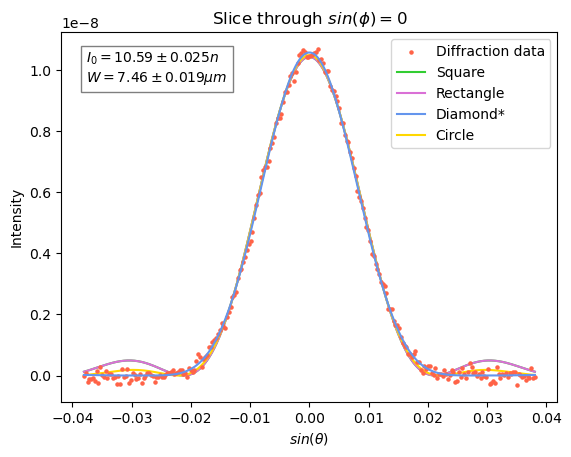

In [345]:
#Extracting index of wehre sin_phi = 0 
if metadata["As Projected"] == 'True': 
    """
    As the calculated projected data sin_phi array does not have a value == 0, take a silce though the middle of the data 
    """
    phi_index = int(len(sin_phi)/2)

else: 
    phi_index = np.where(sin_phi == 0.)[0][0]

#Slicing the data around sin_phi=0.
intensity_slice_phi= intensity[:, phi_index]
        
#Getting optimal parameters for Dimension 1 and I_0 and covariance matrix from fitting functions for every possible shape
popt_1_square, pcov_1_square  = curve_fit(intensity_square, sin_theta, intensity_slice_phi, p0= p0_square)
popt_1_rectangle, pcov_1_rectangle = curve_fit(intensity_rectangle, sin_theta, intensity_slice_phi, p0=p0_rectangle)
popt_1_diamond, pcov_1_diamond= curve_fit(intensity_diamond, sin_theta, intensity_slice_phi, p0=p0_diamond)
popt_1_circle, pcov_1_circle= curve_fit(intensity_circle, sin_theta, intensity_slice_phi, p0=p0_circle)


plt.figure()
#Plotting the original data and the fitted curve
plt.scatter(sin_theta, intensity_slice_phi, s = 5, c = 'tomato', label='Diffraction data', zorder = 4)

#Plotting fitted curves for all possible shapes
plt.plot(sin_theta, intensity_square(sin_theta, *popt_1_square), c = 'limegreen', label='Square')
plt.plot(sin_theta, intensity_rectangle(sin_theta, *popt_1_rectangle), c= 'orchid', label='Rectangle')
plt.plot(sin_theta, intensity_diamond(sin_theta, *popt_1_diamond), c='cornflowerblue', label='Diamond*', zorder = 5)
plt.plot(sin_theta, intensity_circle(sin_theta, *popt_1_circle), c='gold', label='Circle')

#Adding labels and legend and manually approximating the results 
plt.xlabel('$sin(\\theta)$')
plt.ylabel('Intensity')
text = '\n'.join((
    r'$I_0 = 10.59 \pm 0.025n  $',
    r'$W= 7.46 \pm 0.019 µm$'))


plt.text(0.05, 0.95, text, transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))



plt.legend()
plt.title('Slice through $sin(\\phi) =0$')
plt.show()

In [346]:
#Calculating Chi squared for every possible shape
chi_1_square = chi_squared(intensity_square(sin_theta, *popt_1_square), intensity_slice_phi, popt_1_square) 
chi_1_rectangle = chi_squared(intensity_rectangle(sin_theta, *popt_1_square), intensity_slice_phi, popt_1_rectangle) 
chi_1_diamond = chi_squared(intensity_diamond(sin_theta, *popt_1_diamond), intensity_slice_phi, popt_1_diamond) 
chi_1_circle = chi_squared(intensity_circle(sin_theta, *popt_1_circle), intensity_slice_phi, popt_1_circle) 

In [347]:
# Determining which shape has the smallest chi-squared 
if metadata["shape"] == 'random':

    """
    If the shape of the aperure is unknown determine the shape by finding one with the smallest chi-squared.
    If the shape is known, automatically assign shape = metadata['shape']
    """   
    
    #Creating a dictionary of chi_squared for every possible shape:
    chi_squareds = {
        'square':[chi_1_square],
        'rectangle': [chi_1_rectangle],
        'diamond': [chi_1_diamond],
        'circle':[chi_1_circle]
        }
    shape = min(chi_squareds, key=chi_squareds.get)
else:
    shape = metadata['shape']

print(shape)

diamond


## 4.3 Fit another slice of the data with a suitable function.

For square and rectangular apertures, you should also fit the data for  sin𝜃=0
  to determine the size of the aperture in the other axis i.e. a value for  𝐿
 . If the aperture is rectangular then  𝐿
  is at least 1 micron different from  𝑊
 . This will be "dimension 2" when you return the results.

For diamond and circular apertures you will probably want to fit the data in the direction  sin𝜃=sin𝜙
  - note that the total angle is then  𝜃2+𝜙2⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√
 .

For square, diamond, and circular apertures, the two dimensions in the results will be the same, but you should still return two sets of numbers for "dimension 1" and "dimension 2".

Again, you should also make a plot showing the data you were fitting and the fit(s) found. If you have fitted the data with more than one function, you should indicate on the legend or with a text annotation, which function is the best fit.

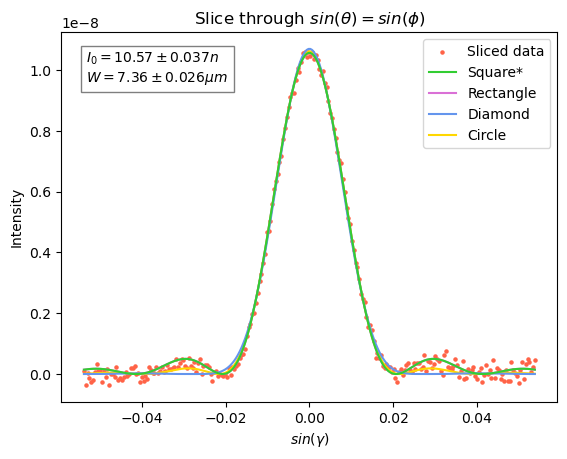

In [348]:
if shape == 'rectangle' or shape == 'square': 
    """
    If shape is either rectangle or square we slice through sin_theta = 0 and compare the dimentions for rectangle and square.
    If the dimensions are diffrent by more than 1 micron then it is a rectangle, if they are almost the same its a square. 
    """
    if metadata["As Projected"] == 'True': 
        """
        As the calculated projected data sin_theta array does not have a value == 0, take a silce though the middle of the data 
        """
        theta_index = int(len(sin_theta)/2) 
                                            
    else: 
        theta_index = np.where(sin_theta == 0.)[0][0]

    #Extracting the slice of data for sin_theta=0
    intensity_slice_theta = intensity[theta_index, : ]

    #Getting optimal parameters for Dimension 2 and I_0 and covariance matrix from fitting functions for every possible shape
    popt_2_square, pcov_2_square  = curve_fit(intensity_square, sin_phi, intensity_slice_theta, p0= p0_square)
    popt_2_rectangle, pcov_2_rectangle = curve_fit(intensity_rectangle, sin_phi, intensity_slice_theta, p0=p0_rectangle)
    popt_2_diamond, pcov_2_diamond= curve_fit(intensity_diamond, sin_phi, intensity_slice_theta, p0=p0_diamond)
    popt_2_circle, pcov_2_circle= curve_fit(intensity_circle, sin_phi, intensity_slice_theta, p0=p0_circle)

    plt.figure()
    #Plotting the original data and the fitted curve
    plt.scatter(sin_phi, intensity_slice_theta, s = 5, c = 'tomato', label='Diffraction data', zorder = 10)
    #Plotting fitted curves for every possible shape
    plt.plot(sin_phi, intensity_square(sin_phi, *popt_2_square), c = 'limegreen', label='Square')
    plt.plot(sin_phi, intensity_rectangle(sin_phi, *popt_2_rectangle), c= 'orchid', label='Rectangle')
    plt.plot(sin_phi, intensity_diamond(sin_phi, *popt_2_diamond), c='cornflowerblue', label='Diamond*',zorder = 5)
    plt.plot(sin_phi, intensity_circle(sin_phi, *popt_2_circle), c='gold', label='Circle')

    plt.xlabel('$sin(\\phi)$')
    plt.ylabel('Intensity')
    text = '\n'.join((
        r'$I_0 = 10.57 \pm 0.03n  $',
        r'$W= 7.44 \pm 0.021 µm$'))


    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


    plt.legend()
    plt.title('Slice through $sin(\\theta) =0$')
    plt.show()


    #Checking if the shape is a square or rectangle based on the leghth of the dimentions
    if popt_1_rectangle[1]*1e6-popt_2_rectangle[1]*1e6 >1: 
        shape = 'rectangle'
    else: 
        shape = 'square'


else: 
    """
    If the shape is either diamond or circle we want to double check which one it is by taking a diagonal slice and comparing it's fits to 
    square and circle. If the shape is diamond, the diagonally sliced data will fit the square. If its a circle it will not change. 
    """
    diagonal_slice = np.diagonal(intensity)

    theta = np.arcsin(sin_theta)
    phi = np.arcsin(sin_phi)
    
    sin_gamma =  np.sin(np.sqrt(theta**2+phi**2))

    middle_index_gamma = int(len(sin_gamma)/2)

    #Converting half of the array back to negatives as they became positive after takinf squares of the angles
    sin_gamma[:middle_index_gamma] *= -1

    popt_2_square, pcov_2_square  = curve_fit(intensity_square, sin_gamma, diagonal_slice, p0= p0_square)
    popt_2_rectangle, pcov_2_rectangle= curve_fit(intensity_rectangle, sin_gamma, diagonal_slice, p0=p0_rectangle)
    popt_2_diamond, pcov_2_diamond_= curve_fit(intensity_diamond, sin_gamma, diagonal_slice, p0=p0_diamond)
    popt_2_circle, pcov_2_circle = curve_fit(intensity_circle, sin_gamma, diagonal_slice, p0= p0_circle)
       
    
    plt.figure()
    #Plotting the diagonal slice
    plt.scatter(sin_gamma, diagonal_slice, s = 5, c = 'tomato', label='Sliced data')
    #Plotting fitted curves for every possible shape
    plt.plot(sin_gamma, intensity_square(sin_gamma, *popt_2_square), c = 'limegreen', label='Square*', zorder = 10)
    plt.plot(sin_gamma, intensity_rectangle(sin_gamma, *popt_2_rectangle), c= 'orchid', label='Rectangle')
    plt.plot(sin_gamma, intensity_diamond(sin_gamma, *popt_2_diamond), c='cornflowerblue', label='Diamond',zorder = 5)
    plt.plot(sin_gamma, intensity_circle(sin_gamma, *popt_2_circle), c='gold', label='Circle')
    plt.xlabel('$sin(\\gamma)$')
    plt.ylabel('Intensity')

    text = '\n'.join((
    r'$I_0 = 10.57 \pm 0.037n  $',
    r'$W= 7.36 \pm 0.026 µm$'))
    plt.text(0.05, 0.95, text, transform=plt.gca().transAxes,
        fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


    plt.legend()
    plt.title('Slice through $sin(\\theta)=sin(\\phi)$')
    plt.show()

    #Calculating chi-squared for square and circle
    chi_2_square = chi_squared(intensity_square(sin_gamma, *popt_2_square), diagonal_slice, popt_2_square)
    chi_2_circle = chi_squared(intensity_circle(sin_gamma, *popt_2_circle), diagonal_slice, popt_2_circle) 

    #Determining if the shape is circle or diamond based on chi squared for circle and square for diagonal slice: 
    if chi_2_square < chi_2_circle:
        shape = 'diamond'

    else: 
        shape = 'circle'

## 4.4 Determine the shape of the aperture

If your code works with randomly chosen aperture shapes, then it should work out what shape of aperture it is processing data from.

In any case, your code should report the shape of the aperture it has found in the results, even if it only works with a single aperture shape.

In [349]:
def calculate_answers(shape):
    """
    This function calculates the final results of the project from the fitted popt and pcov values based on the found shape. 
    It returns all answers needed for the ProcessData(filename) function.

    Parameters
    ----------
    shape: string

    Returns
    -------
    dim_1: float 
        Dimension 1 in microns
    dim_1_err: float
        Uncertainity of Dimension 1
    dim_2: float
        Dimension 2 in microns
    dim_2_err: float
        Uncertainity of Dimension 1
    I0_per_A: float 
        Intensity per area in W/m^2
    I0_per_A_err: float
        Error of the Intensity per Area
    """

    def calculate_I0_per_A_err(dim_1, dim_1_err, dim_2, dim_2_err, I_0, A, I0_err, I0_per_A): 
        """
        This function calculates the uncertainity of the Intensity per Area value. It also checks the sanity of the answers 
        for the dimensions are not in the predicted range. 
        
        Parameters
        ----------
        dim_1: float 
        dim_1_err: float
        dim_2: float
        dim_2_err: float 
        I0: float
            Maximum intensity (found from fitted parameters)
        A: float
            Area of the apperture  
        I0_err: float
        I0_per_A: float

        Returns
        -------
        I0_per_A_err: float
            Error of the Intensity per Area. 
        """
        dA = np.sqrt((dim_1_err/dim_1)**2 + (dim_2_err/dim_2)**2) * A
        I0_per_A_err = np.sqrt((dA/A)**2 + (I0_err/I_0)**2) * (I0_per_A)
        return I0_per_A_err


    if shape == 'square':
        dim_1 = popt_1_square[1]*1e6
        dim_2 = popt_2_square[1]*1e6
        dim_1_err = np.sqrt(np.diag(pcov_1_square))[1]*1e6
        dim_2_err = np.sqrt(np.diag(pcov_2_square))[1]*1e6
        I_0 = popt_1_square[0]
        A = popt_1_square[1]*popt_2_square[1]
        I0_per_A = I_0 / A
        I0_per_A_err  = calculate_I0_per_A_err(dim_1,dim_1_err, dim_2, dim_2_err,I_0, A, np.sqrt(np.diag(pcov_1_square))[0], I0_per_A  )
        
        
    elif shape == 'rectangle':
        dim_1 = popt_1_rectangle[1]*1e6
        dim_2 = popt_2_rectangle[1]*1e6
        dim_1_err = np.sqrt(np.diag(pcov_1_rectangle))[1]*1e6
        dim_2_err = np.sqrt(np.diag(pcov_2_rectangle))[1]*1e6
        I_0 = popt_1_rectangle[0]
        A = popt_1_rectangle[1]*popt_2_rectangle[1]
        I0_per_A = I_0 / A
        I0_per_A_err  = calculate_I0_per_A_err(dim_1,dim_1_err, dim_2, dim_2_err, I_0, A, np.sqrt(np.diag(pcov_1_rectangle))[0], I0_per_A )

    elif shape == 'diamond':
        dim_1 = popt_1_diamond[1]*1e06 #extracting dim_1 and converting it to microns
        dim_2 = popt_2_square[1]*1e06 #extracting dim_2 and converting it to microns
        dim_1_err = np.sqrt(np.diag(pcov_1_diamond))[1]*1e06
        dim_2_err = np.sqrt(np.diag(pcov_2_square))[1]*1e06
        I_0 = popt_1_diamond[0]
        A = popt_1_diamond[1]*popt_2_square[1]
        I0_per_A = I_0 / A
        I0_per_A_err =  calculate_I0_per_A_err(popt_1_diamond[1],np.sqrt(np.diag(pcov_1_diamond))[1], popt_2_square[1], np.sqrt(np.diag(pcov_2_square))[1], I_0, A, np.sqrt(np.diag(pcov_1_diamond))[0], I0_per_A)

    elif shape == 'circle': 
        dim_1 = popt_1_circle[1]*1e6
        dim_2 = popt_2_circle[1]*1e6
        dim_1_err = np.sqrt(np.diag(pcov_1_circle))[1]*1e6
        dim_2_err = np.sqrt(np.diag(pcov_2_circle))[1]*1e6
        I_0 = popt_1_circle[0]
        A = math.pi*(0.5*dim_1)**2
        I0_per_A = I_0 / A
        I0_per_A_err =  calculate_I0_per_A_err(dim_1, dim_1_err, dim_2, dim_2_err, I_0, A, np.sqrt(np.diag(pcov_1_circle))[0], I0_per_A)

    #Checking the sanity of the answers: 
    if not (1 <= dim_1 <= 40 and 1 <= dim_2 <= 40):  
        raise ValueError('Dimensions are not in the correct range (1 to 40)!')



    return dim_1, dim_1_err, dim_2, dim_2_err, I0_per_A, I0_per_A_err


dim_1, dim_1_err, dim_2, dim_2_err, I0_per_A, I0_per_A_err = calculate_answers(shape)


## Template

In [350]:
def ProcessData(filename):
    """
    This function takes the found results from calculate_answers function and the rest of the code, and creates the dictionary 
    for the autograder.
    
    Parameters
    ----------
    filename: string
        Path to the data file

    Returns
    -------
    results: dictionary
    """
    
    #This is the data structure to return your results with - 
    # replace the None values with your answers. Do not 
    # rename any of the keys, do not delete any of the keys
    # - if your code doesn't find a value, leave it as None here.    
    results = {
        "shape": shape, # one of "square", "rectangle", "diamond", "circle" - must always be present.
        "dim_1": dim_1, # a floating point number of the first dimension expressed in microns
        "dim_1_err": dim_1_err, # The uncertainty in the above, also expressed in microns
        "dim_2":dim_2, # For a rectangle, the second dimension, for other shapes, the same as dim_1
        "dim_2_err": dim_2_err,  # The uncertainty in the above, also expressed in microns
        "I0/area": I0_per_A, # The fitted overall intensity value/area of the aperture.
        "I0/area_err": I0_per_A_err, # The uncertainty in the above.
    }
    return results

In [351]:
if __name__=="__main__":
     # Put your test code in side this if statement to stop 
     #it being run when you import your code

     filename="My Data File.txt"
     test_results=ProcessData(filename)
     print(test_results)

{'shape': 'diamond', 'dim_1': 7.464608633832224, 'dim_1_err': 0.01949455311857134, 'dim_2': 7.356040017710066, 'dim_2_err': 0.02633789575482882, 'I0/area': 192.85555813763153, 'I0/area_err': 0.9654332357602884}
